# Predict Whether The Chest Pain is Symptomatic Based on Old Peak, Age, and Maximum Heart Rate

## Introduction:

Recently, with the fast development in healthcare systems, the public has started to insert more attention towards healthcare, especially heart disease, the second major cause of death. Therefore, we decided to build a model related to one particular heart disease, Angina.

Angina is a heart disease that makes patients feel strong, squeezed chest pain. If the case is severe, hospitalization is required. Possible symptoms include dizziness, nausea, and/or shortness of breath. Furthermore, there are four types of angina:

**Typical angina** consists of 3 main criteria: 
* It is a substernal chest discomfort or pain.
* It is mainly caused from emotional stress or exertion.
* Symptoms can be relieved from nitroglycerine or rest (or both).

**Atypical angina** consists of 2 out of the 3 criteria found in a typical angina.

**Non-anginal** chest pain has very similar symptoms to typical angina, but with a shorter period and doesn’t satisfy any of the 3 criteria of classic chest pain.

**Asymptomatic chest pain** occurs when the patient shows no signs of common angina symptoms.

### Question:

Given measurements of a patient’s old peak, age, and maximum heart rate, would the patient's chest pain by symptomatic?



### Dataset Used:

We will use "Heart Attack Analysis & Prediction Dataset" to answer the question.

https://www.kaggle.com/rashikrahmanpritom/heart-attack-analysis-prediction-dataset?select=heart.csv

We chose this dataset because it is very inclusive, containing a few hundred different cases. Moreover, it also examines many different variables, such as resting blood pressure, cholesterol, age, etc. Variety in cases can boost the accuracy and conclusiveness of our prediction model. 

## Preliminary exploratory data analysis:

#### Variables:
1. age - age of patient
2. sex - sex of patient
3. cp - type of chest pain:
    - 0 == asymptomatic
    - 1 = typical angina
    - 2 = atypical angina
    - 3 = non-anginal pain
4. trtbps - resting blood pressure (mm Hg) at time admitted to hospital
5. chol - serum cholestoral (mg/dl)
6. fbs - fasting blood sugar > 120 mg/dl (1 = true; 0 = false)
7. restecg - resting electrocardiographic results
    - 0 = hypertrophy
    - 1 = normal
    - 2 = having ST-T wave abnormality
8. thalach - maximum heart rate achieved
9. exang - exercise induced angina:
    - 1 = yes
    - 0 = no
10. oldpeak - ST depression caused by rest relative to exercise
11. slp - slope of peak exercise ST segment
    - 0 = downsloping
    - 1 = flat
    - 2 = upslopting
12. caa - # of flourosopy colored major vessels (0-3) 
13. thall:
    - 1 = fixed defect
    - 2 = normal
    - 3 = reversable defect
14. output - predicted attribute - diagnosis of heart disease (angiographic disease status):
    - 0 = < diameter narrowing
    - 1 = > 50% diameter narrowing)

In [2]:
# Running initial packages
library(tidyverse)
library(tidymodels)
library("ggplot2")
library("GGally")

options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [3]:
# Load training and test data
url <- "https://raw.githubusercontent.com/AlexLuo602/group26v2/main/heart.csv"

download.file(url, destfile = "heart.csv")

heart_csv <- read_csv("heart.csv")
heart_csv

Parsed with column specification:
cols(
  age = col_double(),
  sex = col_double(),
  cp = col_double(),
  trtbps = col_double(),
  chol = col_double(),
  fbs = col_double(),
  restecg = col_double(),
  thalachh = col_double(),
  exng = col_double(),
  oldpeak = col_double(),
  slp = col_double(),
  caa = col_double(),
  thall = col_double(),
  output = col_double()
)



age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
57,1,0,130,131,0,1,115,1,1.2,1,1,3,0
57,0,1,130,236,0,0,174,0,0.0,1,1,2,0


In [18]:
set.seed(10)

# split data into training and testing sets
select_heart_csv <- heart_csv %>%
    mutate(chest.pain.type = as_factor(cp)) %>%
    select(chest.pain.type, chol, trtbps, age, thalachh, oldpeak)


separate_class <- select_heart_csv %>% 
    filter(chest.pain.type %in% c(1, 2, 3))

convert_class <- separate_class %>% 
    mutate(symptoms = 'y') 

select_heart_csv <- select_heart_csv %>% 
    filter(chest.pain.type == 0) %>% 
    mutate(symptoms = 'n')

select_heart_csv <- rbind(select_heart_csv, convert_class) %>% 
    mutate(symptoms = as_factor(symptoms)) %>% 
    select(-chest.pain.type)

select_heart_csv %>% 
    group_by(symptoms) %>% 
    summarize(count = n())

heart_split <- initial_split(select_heart_csv, prop = 0.75, strata = symptoms)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

head(heart_train)
head(heart_test)


`summarise()` ungrouping output (override with `.groups` argument)



symptoms,count
<fct>,<int>
n,143
y,160


chol,trtbps,age,thalachh,oldpeak,symptoms
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
354,120,57,163,0.6,n
192,140,57,148,0.4,n
239,140,54,160,1.2,n
247,150,43,171,1.5,n
234,135,59,161,0.5,n
226,140,42,178,0.0,n


chol,trtbps,age,thalachh,oldpeak,symptoms
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
177,120,65,140,0.4,n
260,115,45,185,0.0,n
183,138,35,182,1.4,n
236,138,45,152,0.2,n
325,180,64,154,0.0,n
303,130,64,122,2.0,n


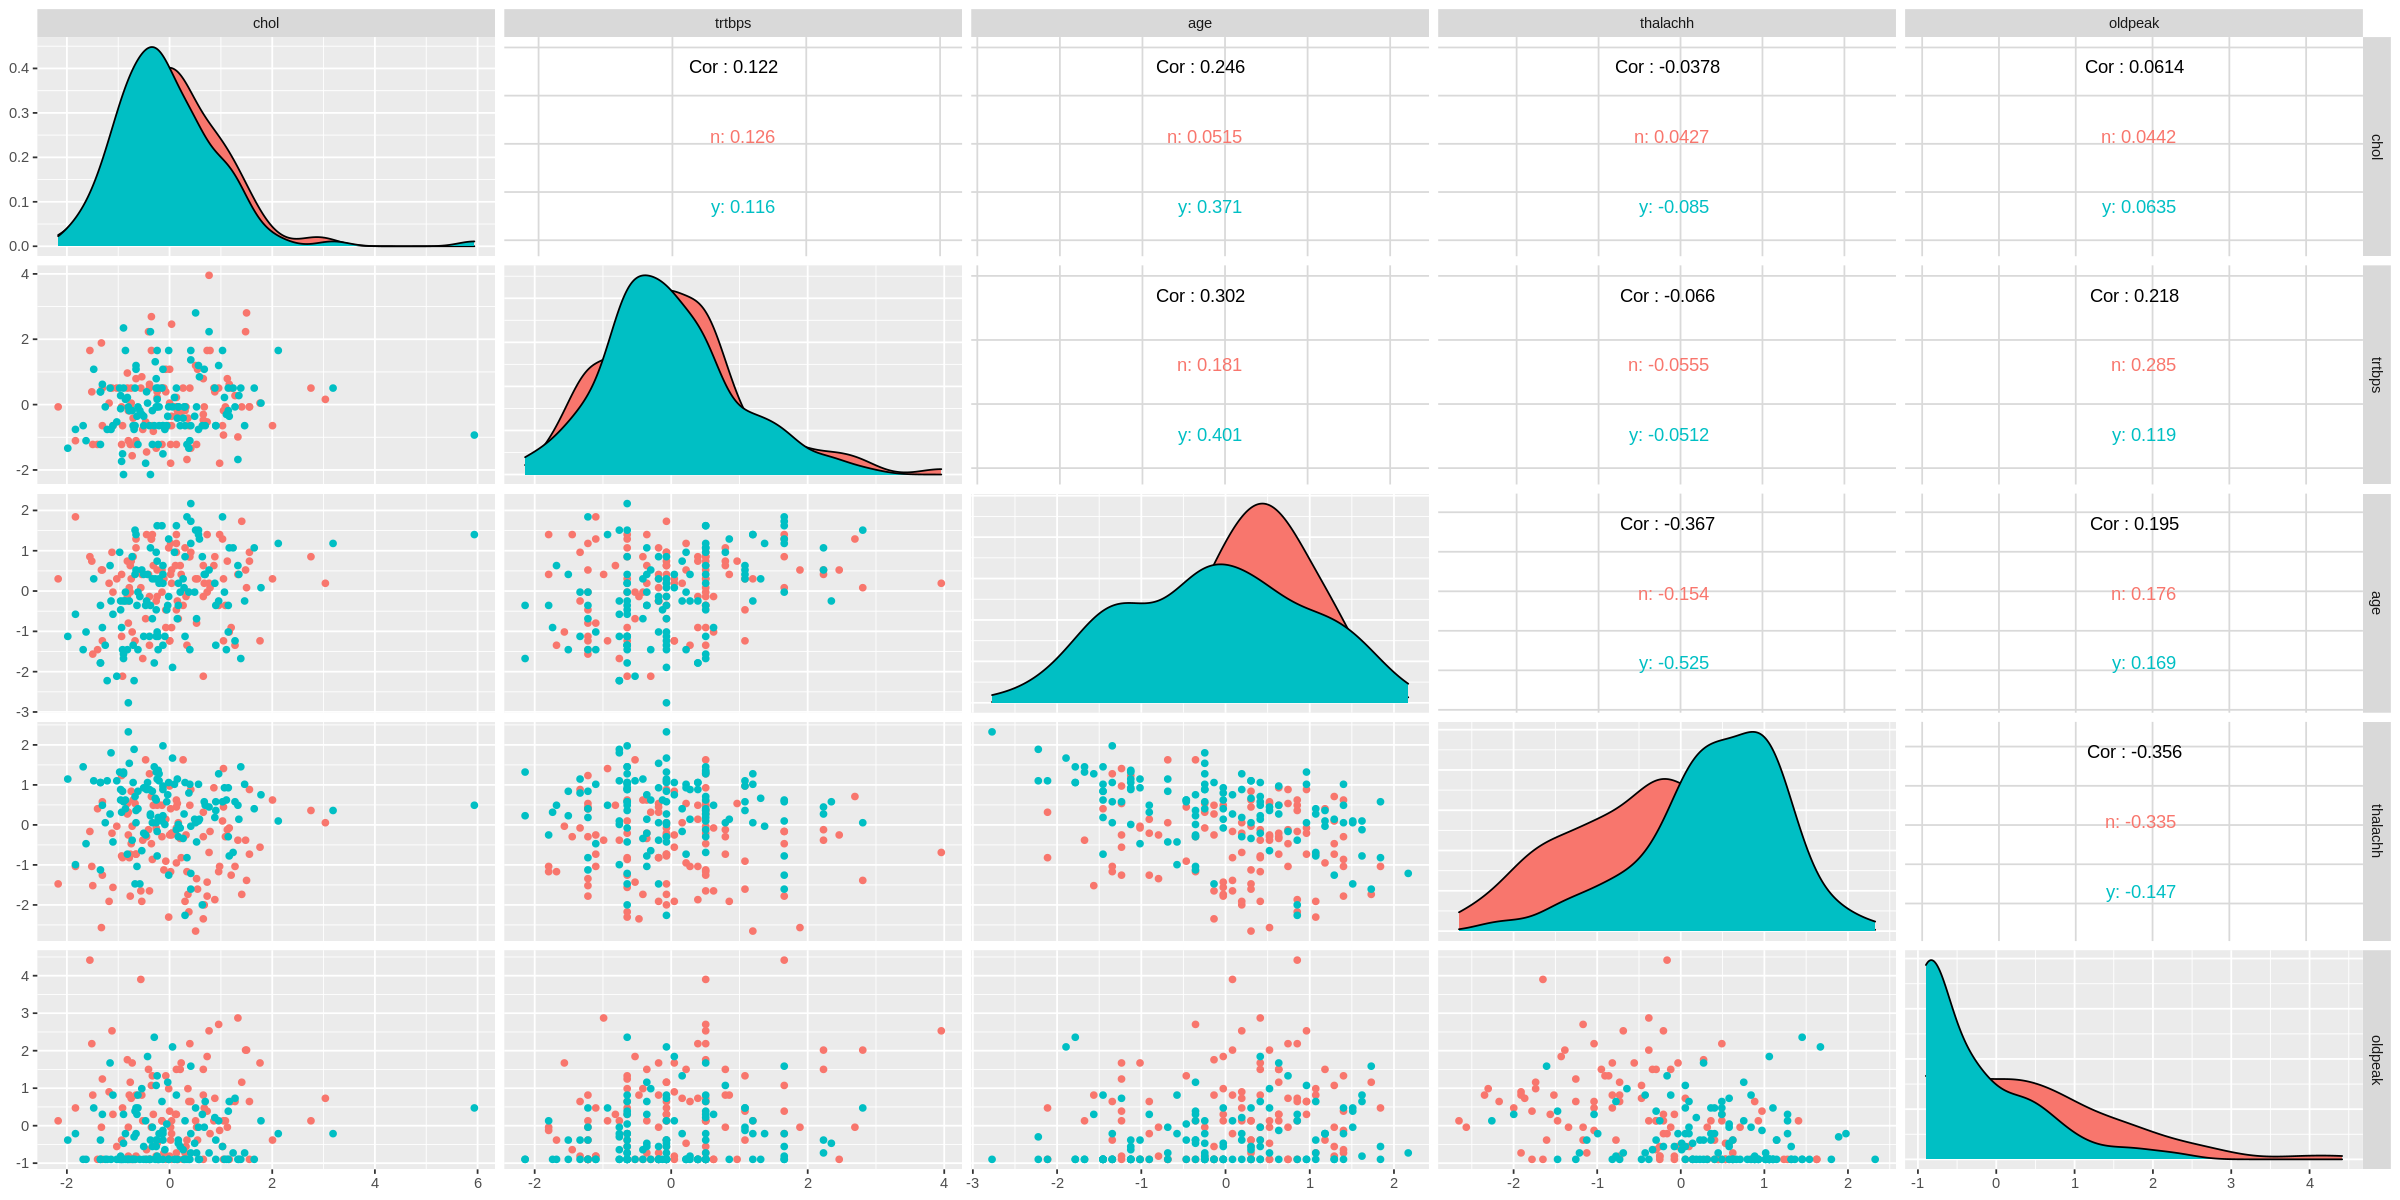

In [19]:
options(repr.plot.width = 20, repr.plot.height = 10)

heart_recipe <- recipe(symptoms ~ ., data = heart_train) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors()) %>%
    prep() %>%
    bake(heart_train)

heart_plots <- ggpairs(heart_recipe, columns = 1:5, ggplot2::aes(colour=symptoms))

heart_plots

# heart_recipe

Out of the 5 possible predictors, age, thalachh (maximum heart rate), and old peak seem to have the best distributions, as the asymptomatic and symptomatic classes peak at different values and don't overlap with each other too much. Therefore, we will use these three predictors

In [20]:
# Summarize the number of observations in each class
heart_observations <- heart_train %>%
    group_by(symptoms) %>% 
    summarize(count = n())

heart_observations

# There is an uneven distribution.

`summarise()` ungrouping output (override with `.groups` argument)



symptoms,count
<fct>,<int>
n,108
y,120


table 1: count of classes

As seen from the table, the classes are balanced, meaning we don't have to take any extra steps to balance them manually.

In [21]:
# Summarize means of each predictor
heart_means <- heart_train %>% 
    summarize(age_mean = mean(age), oldpeak_mean = mean(oldpeak), thalachh_mean = mean(thalachh))
heart_means

age_mean,oldpeak_mean,thalachh_mean
<dbl>,<dbl>,<dbl>
54.24561,1.047807,148.7544


table 2: Mean of Each Predictor

Mean: to see if we need to scale

compare max and min for outliers in data

compare max and min to mean/standard deviation

In [22]:
# There doesn't appear to be any na values in this data set
na_count <- heart_train %>%
  map_df(~sum(is.na(.x)))

na_count

chol,trtbps,age,thalachh,oldpeak,symptoms
<int>,<int>,<int>,<int>,<int>,<int>
0,0,0,0,0,0


## Method & Results

Based on the analysis above, we will be using blood pressure, maximum heart rate, and age as our 3 predictors.

We will use **classification** as our method, with chest pain type as our target variable and the predictors mentioned above.

Since there is an uneven distribution between chest pain types, we need to balance the predictors.

Split our data into 75% training and 25% testing using the initial split function.

Use cross validation to find optimal K by using tuning and vfold_cv on our training set.

Finally, use our model to predict the classes for our testing set, and use metrics to determine accuracy of our model. 

We will visualize the results using a confusion matrix for our classifier and plotting it.


## Code:

Although balancing before cross-validation has some pitfalls, like data leakage, the classes are too imbalanced to not up_sample.

In [23]:
# Create the Recipe

heart_train <- select(heart_train, symptoms, age, oldpeak, thalachh)

heart_recipe <- recipe(symptoms ~ ., data = heart_train) %>% 
    step_scale(all_predictors()) %>%
    step_center(all_predictors())

heart_recipe %>% 
    prep() %>% 
    bake(heart_train)

age,oldpeak,thalachh,symptoms
<dbl>,<dbl>,<dbl>,<fct>
0.30246765,-0.3837621,0.62221206,n
0.30246765,-0.5551583,-0.03294965,n
-0.02697164,0.1304265,0.49117971,n
⋮,⋮,⋮,⋮
0.3024677,-0.8979508,0.66588950,y
1.4005986,-0.2123659,0.05440524,y
0.3024677,-0.8979508,1.10266398,y


In [24]:
# Perform cross validation with 5 folds

heart_vfold <- vfold_cv(heart_train, v = 5, strata = symptoms)

heart_tune <- nearest_neighbor(weight = "rectangular", neighbors = tune()) %>% 
    set_engine("kknn") %>% 
    set_mode("classification")

Try a sequence of 50 neighbors

In [25]:
gridvals = tibble(neighbors = seq(from = 1, to = 50))

vfold_results <- workflow() %>% 
    add_recipe(heart_recipe) %>% 
    add_model(heart_tune) %>% 
    tune_grid(resamples = heart_vfold, grid = gridvals) %>% 
    collect_metrics()

vfold_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.5836715,5,0.03193102,Model01
1,roc_auc,binary,0.5829004,5,0.03269554,Model01
2,accuracy,binary,0.5836715,5,0.03193102,Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
49,roc_auc,binary,0.7297168,5,0.03894462,Model49
50,accuracy,binary,0.6712077,5,0.03467092,Model50
50,roc_auc,binary,0.7329726,5,0.03750373,Model50


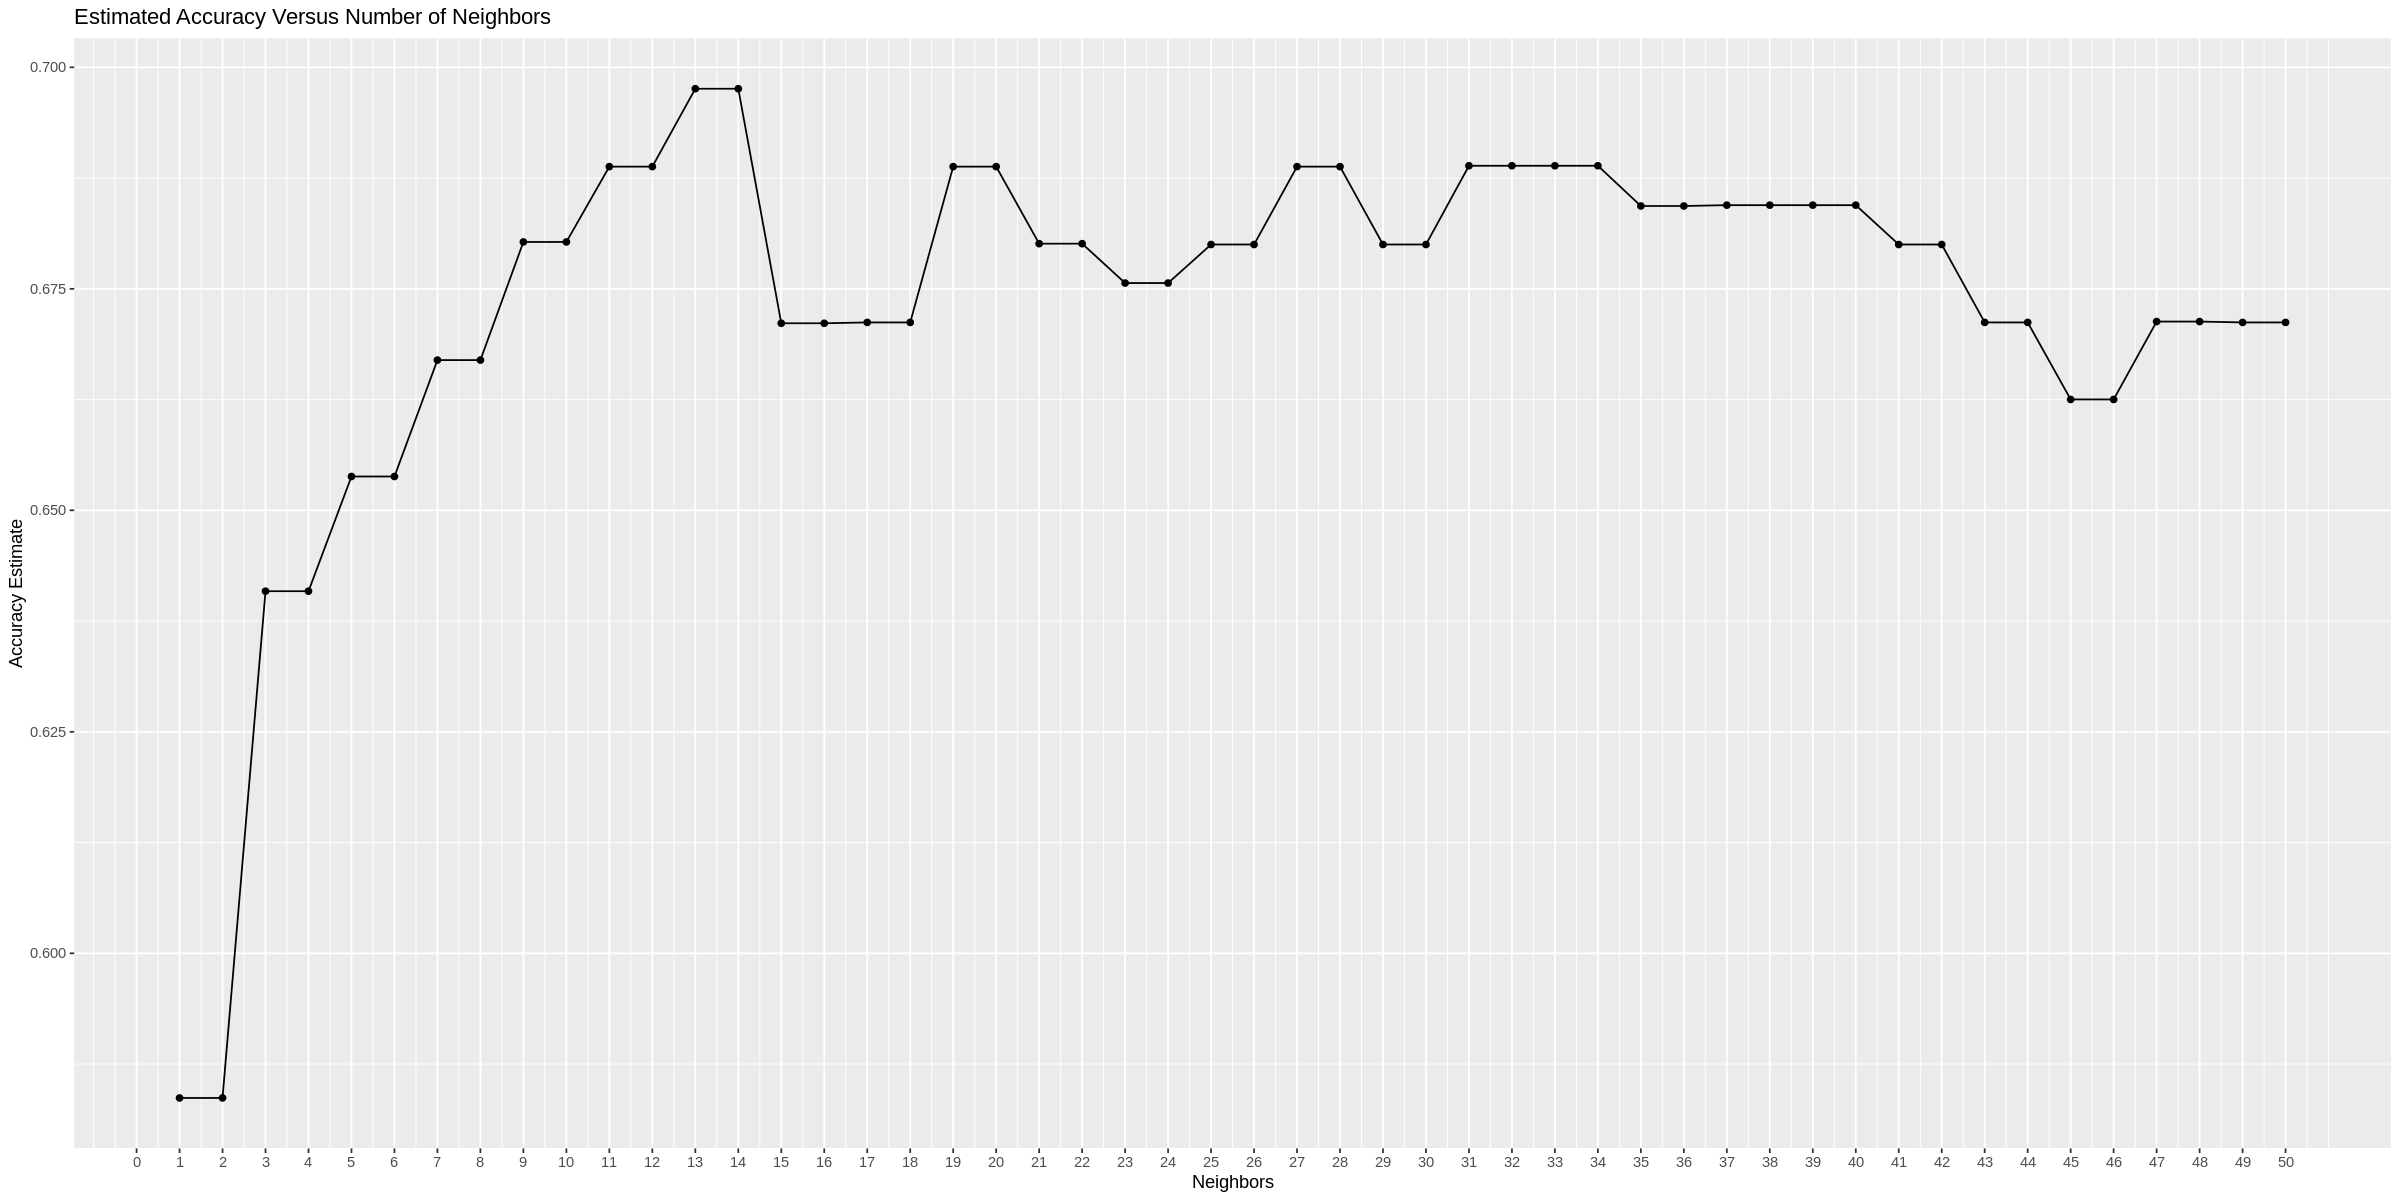

In [26]:
# plot 
options(repr.plot.width = 20, repr.plot.height = 10)
accuracy <- vfold_results %>% 
    filter(.metric == "accuracy")

vfold_plot <- ggplot(accuracy, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    scale_x_continuous(breaks = seq(0, 50, by = 1)) +
    ggtitle("Estimated Accuracy Versus Number of Neighbors")

vfold_plot

Choose k = 44, as that gave the highest accuracy, and nearby k values don't differ by too much.

In [31]:
heart_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 38) %>% 
    set_engine("kknn") %>% 
    set_mode("classification")

heart_fit <- workflow() %>% 
    add_recipe(heart_recipe) %>% 
    add_model(heart_spec) %>% 
    fit(data = heart_train)
heart_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~38, kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.3157895
Best kernel: rectangular
Best k: 38

In [32]:
heart_test_predictions <- predict(heart_fit, heart_test) %>% 
    bind_cols(heart_test)

heart_prediction_accuracy <- heart_test_predictions %>% 
    metrics(truth = symptoms, estimate = .pred_class)

heart_prediction_accuracy

heart_test_predictions

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6400000
kap,binary,0.2649728


.pred_class,chol,trtbps,age,thalachh,oldpeak,symptoms
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
y,177,120,65,140,0.4,n
y,260,115,45,185,0.0,n
y,183,138,35,182,1.4,n
⋮,⋮,⋮,⋮,⋮,⋮,⋮
n,273,160,59,125,0.0,y
y,204,134,59,162,0.8,y
n,264,110,45,132,1.2,y


In [33]:
heart_mat <- heart_test_predictions %>% 
    conf_mat(truth = symptoms, estimate = .pred_class)

heart_mat

          Truth
Prediction  n  y
         n 17  9
         y 18 31

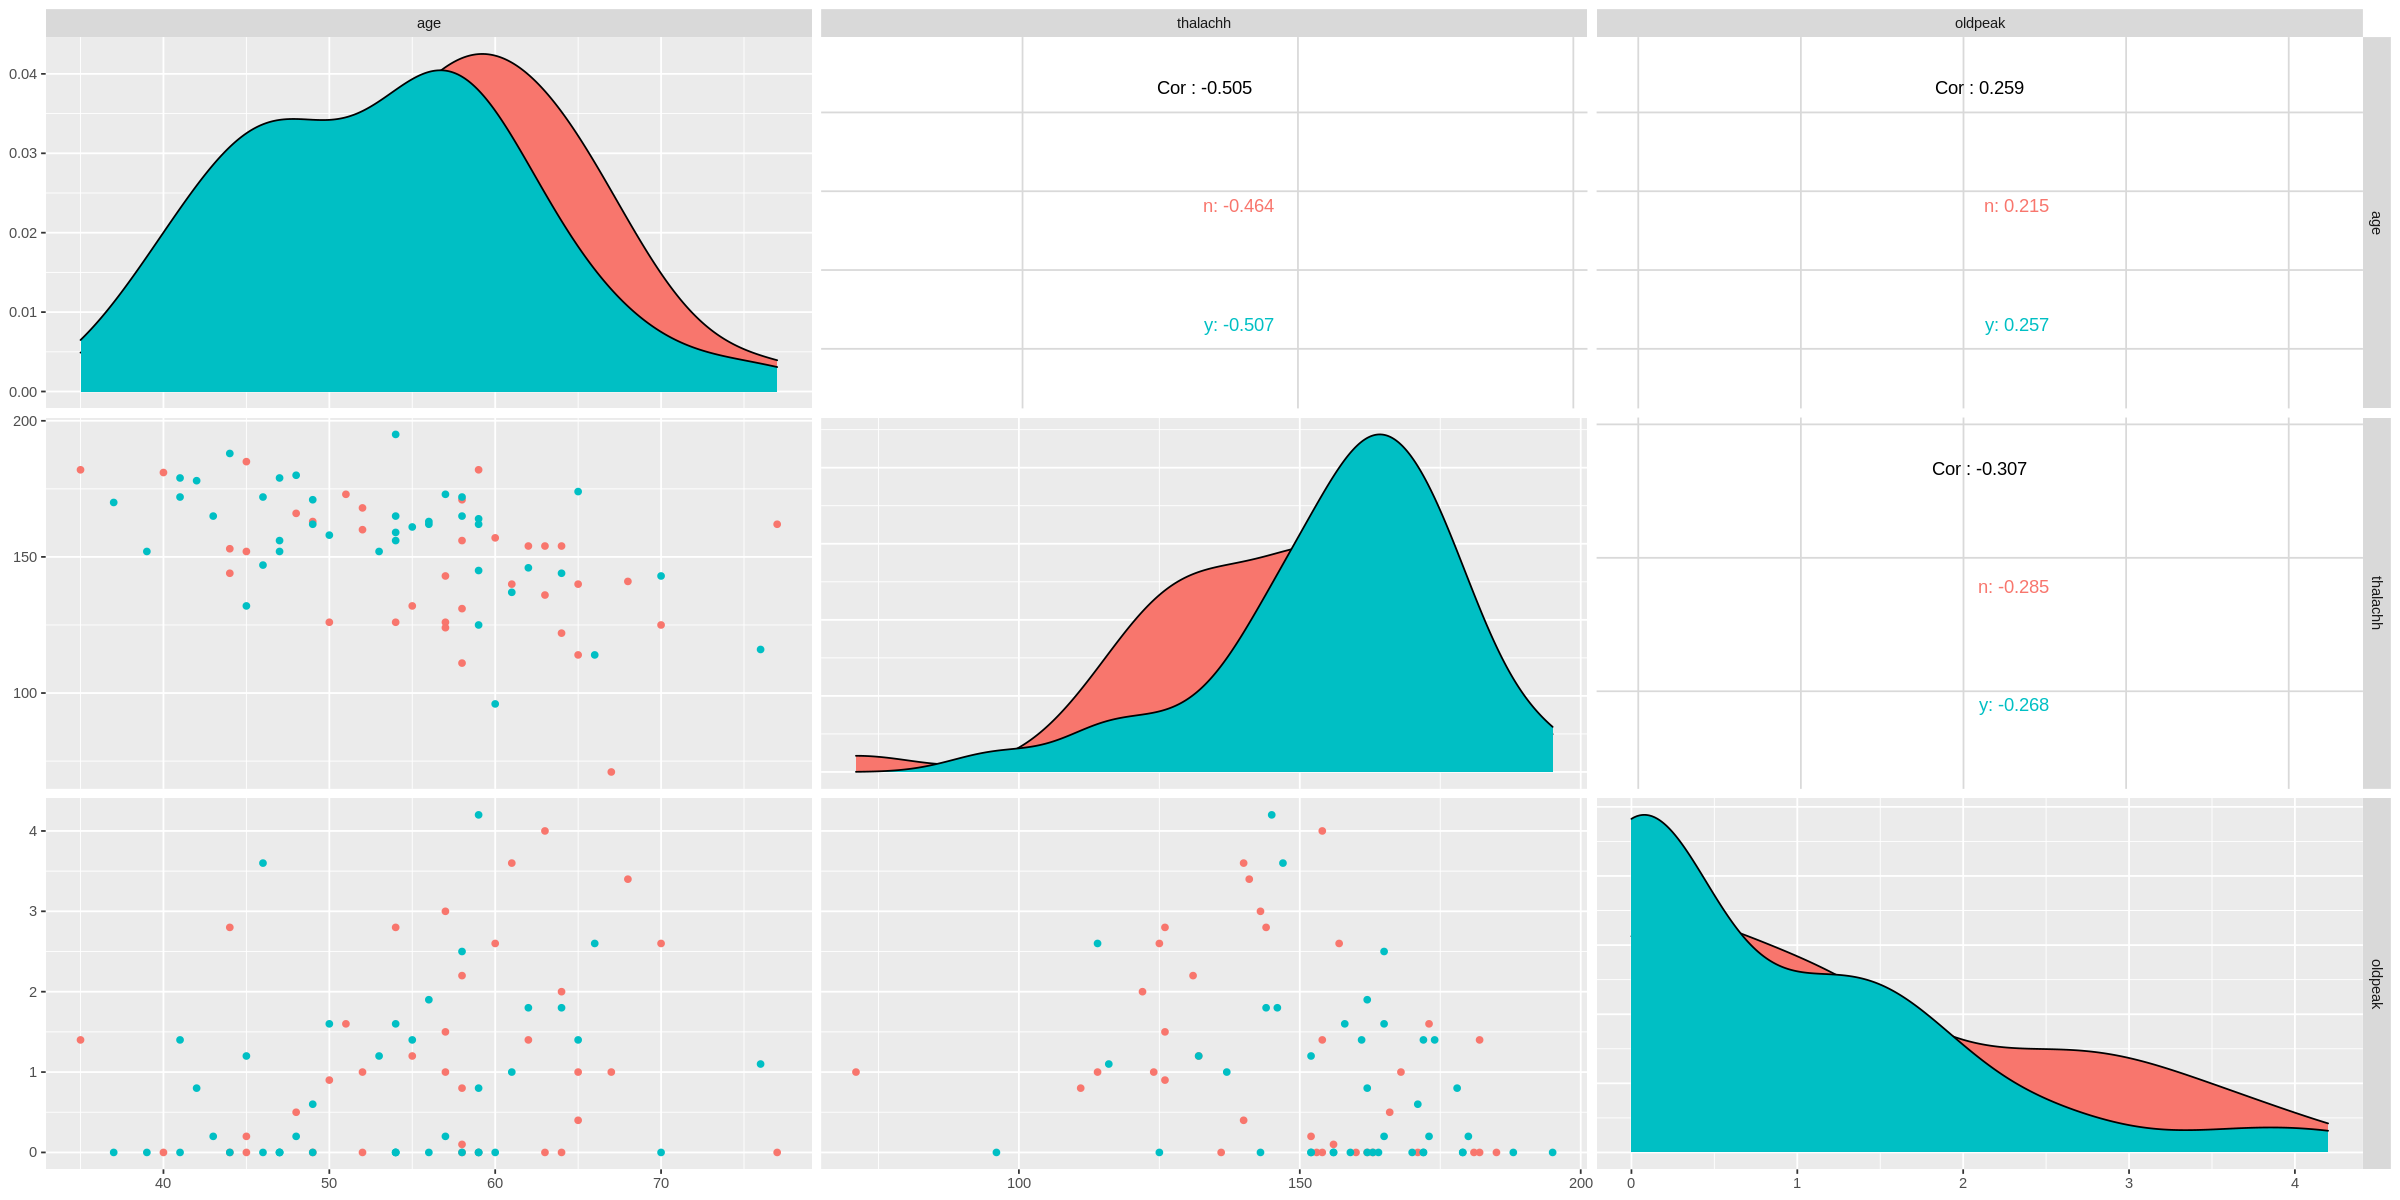

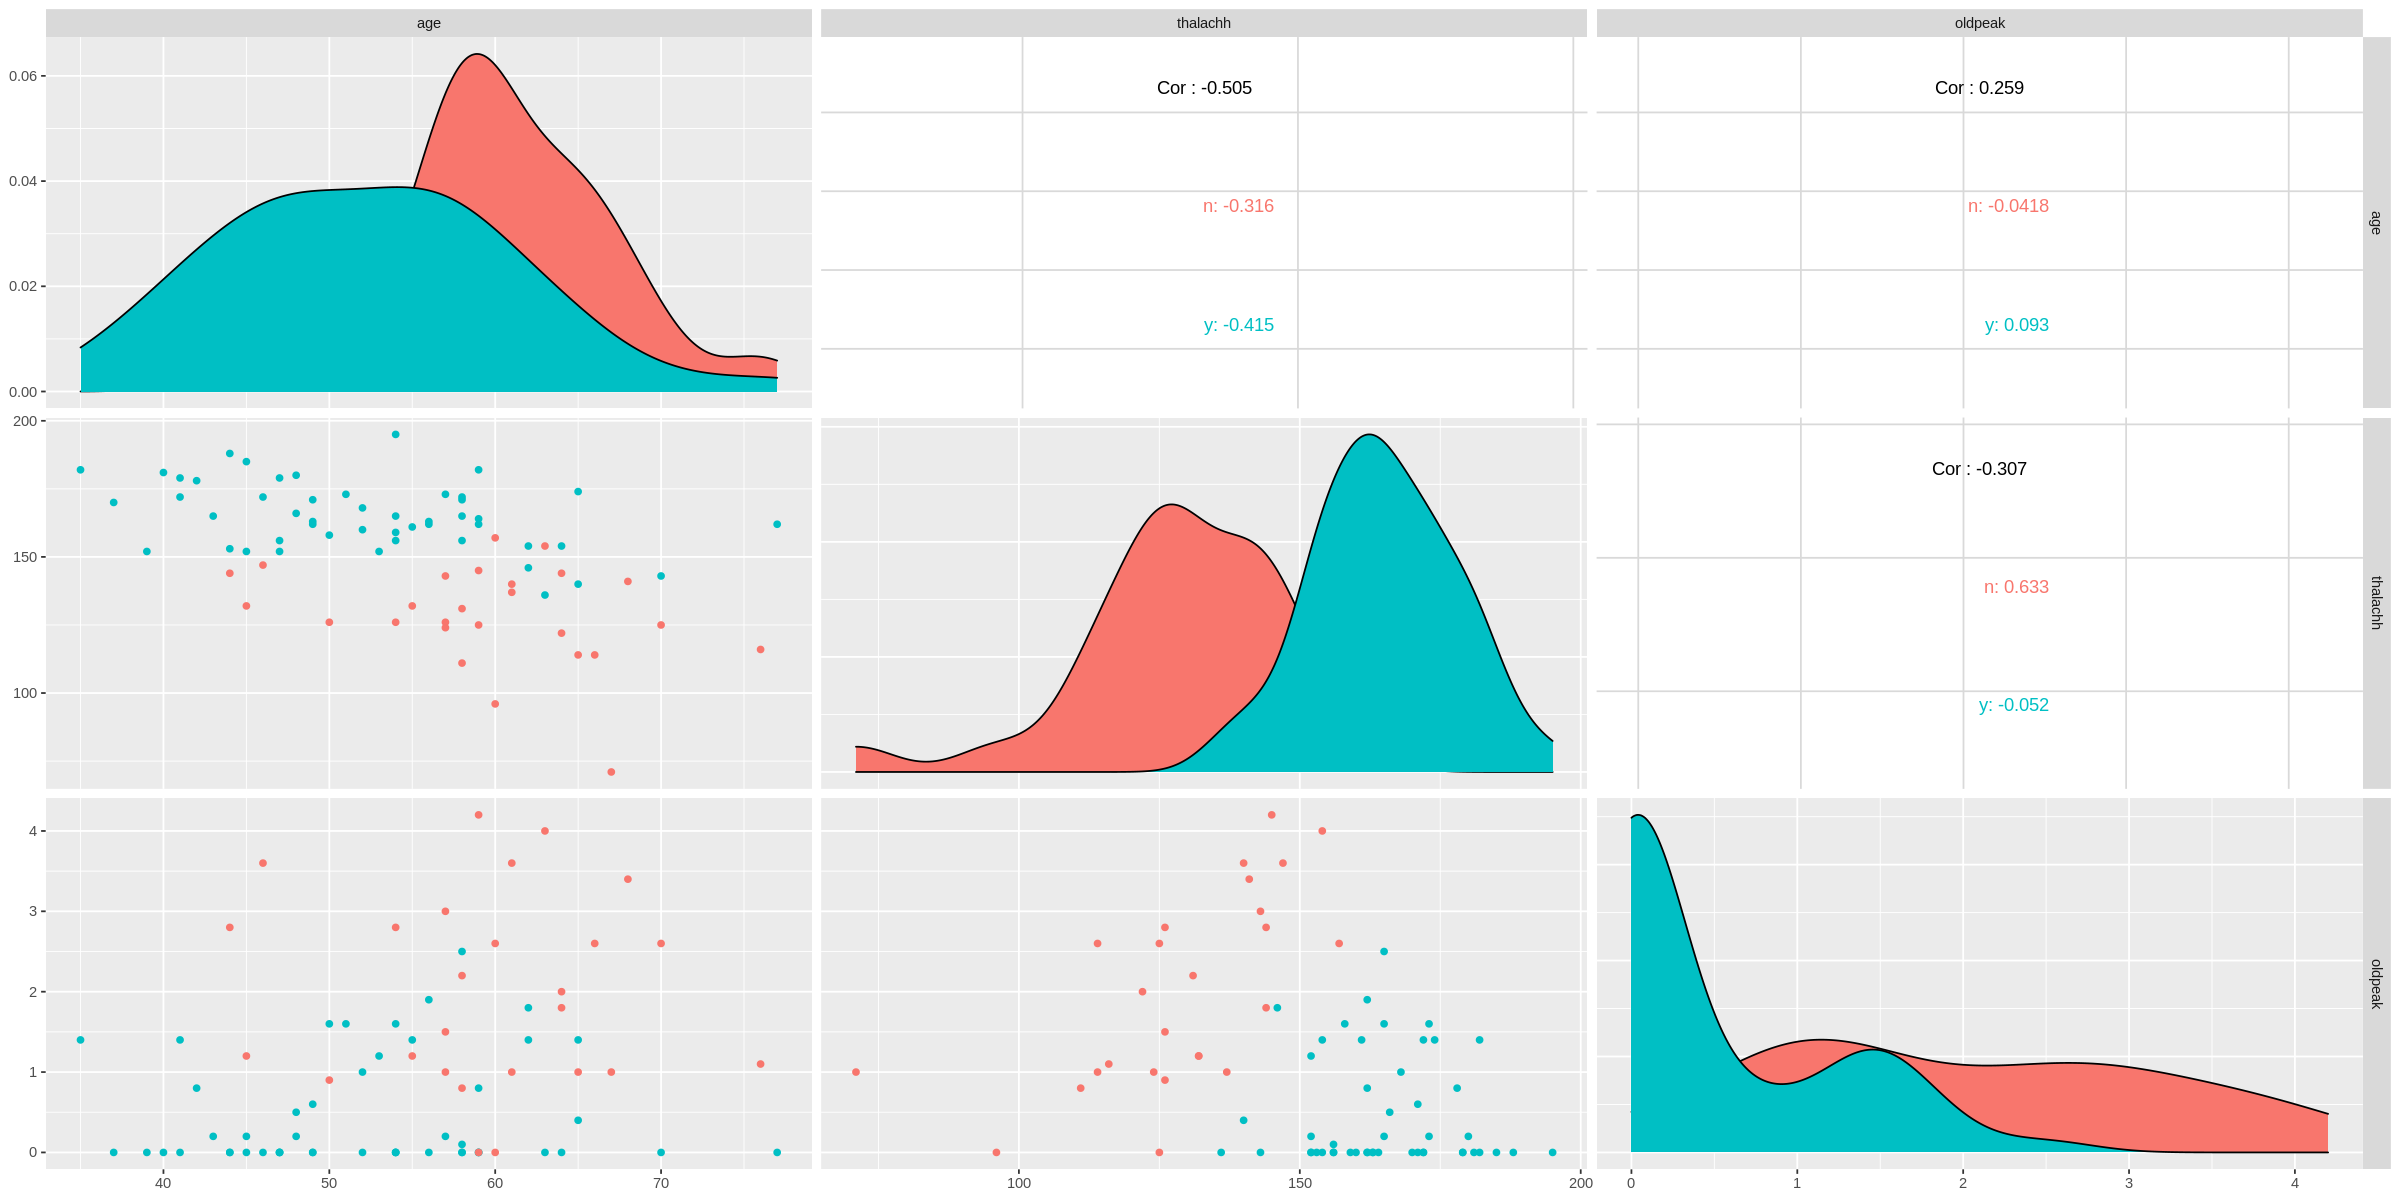

In [34]:
# compare actual plot distribution and predicted plot distribution
actual_plot <- heart_test_predictions%>%
    ggpairs(columns = 4:6, ggplot2::aes(colour=symptoms))

predict_plot <- heart_test_predictions%>%
    ggpairs(columns = 4:6, ggplot2::aes(colour=.pred_class))


actual_plot 
predict_plot

2 columns: first column is true, second column is predicted
3 rows: 1 for each predictor

library(cowplot)

plot_grid(plot1, plot2)

@487

## Visualization of Results

## Discussion:

**Findings**



**Expectations Versus Results**

defined before analysis, expected accuracy to be higher or to be more correlated predictors


**Potential Impacts**

Although official diagnosis should still be performed by a doctor, patients with mild chest pain can self-diagnose the type of chest pain they are experiencing and perform self-treatment.


**Future Questions**

How would adding more predictors change the accuracy of our model?

Would our accuracy improve if we had more observations in our training set?


## References

In [ ]:
(1)


(1)
APA citation